<a href="https://colab.research.google.com/github/zjzsu2000/CMPE297_Sec49AdvanceDL/blob/master/Assignment_7/Assignment_7_Gradient_boost_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
from fastai.imports import *
from IPython.display import display
from sklearn import metrics

In [14]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)
class Decision_tree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_vars()
        
    def find_vars(self):
        for i in range(self.c): self.find_betters(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = Decision_tree(self.x, self.y, self.idxs[lhs])
        self.rhs = Decision_tree(self.x, self.y, self.idxs[rhs])

    def find_betters(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): 
      return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): 
      return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): 
      return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## Data simulation

In [15]:
x = np.arange(0,80)
x = pd.DataFrame({'x':x})

In [16]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(20,25,20)
y2 = np.random.uniform(30,35,20)
y3 = np.random.uniform(0,10,20)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(15,19,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]


##Plot data

In [17]:
x.shape, y.shape

((80, 1), (80, 1))

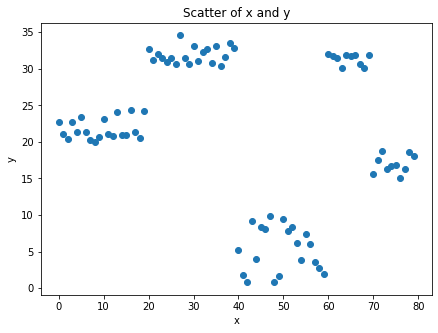

In [18]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter of x and y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Gradient Boosting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

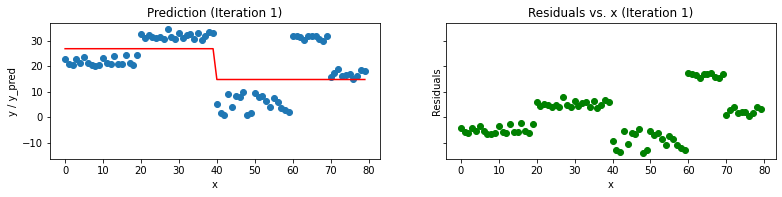

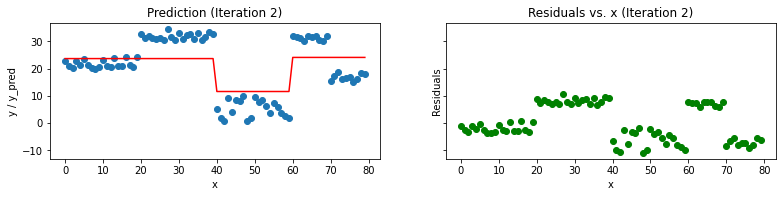

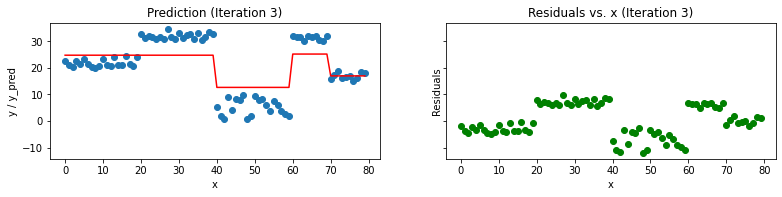

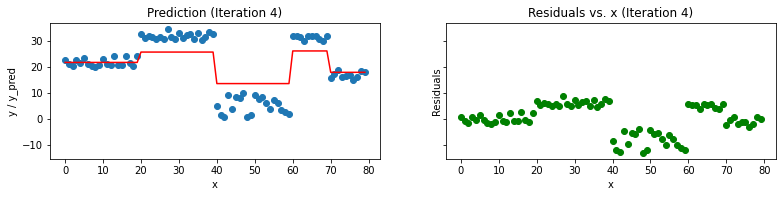

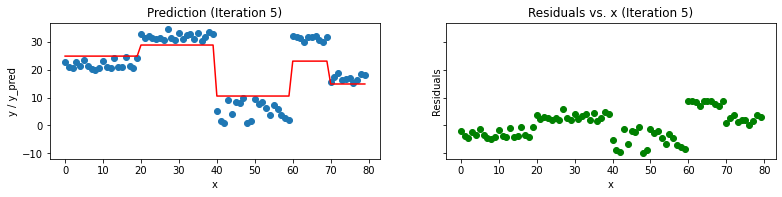

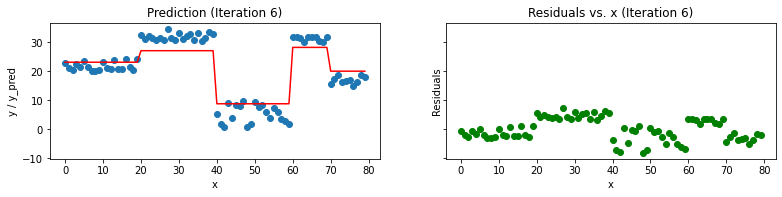

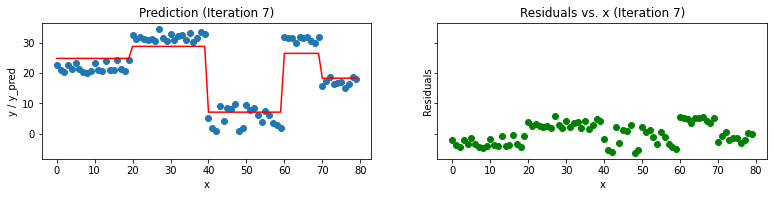

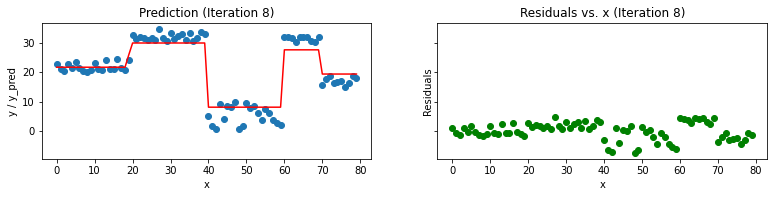

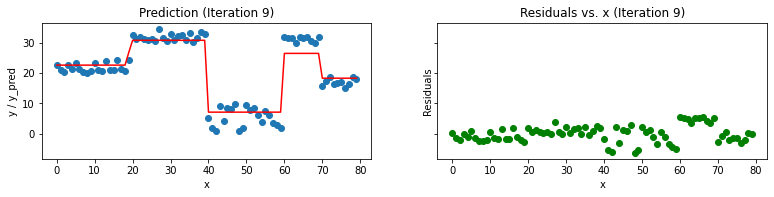

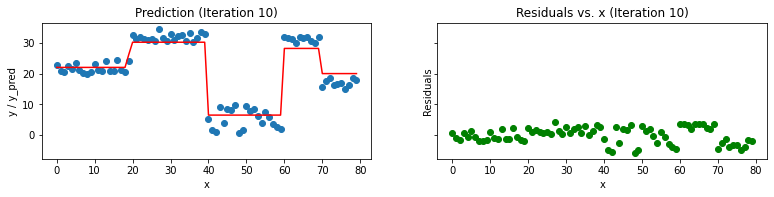

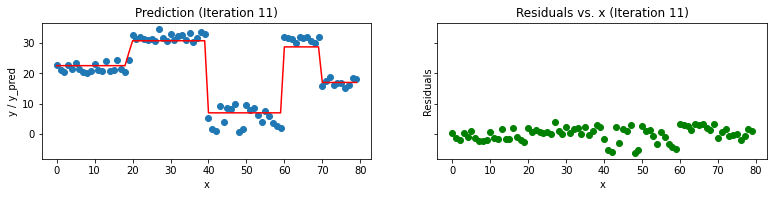

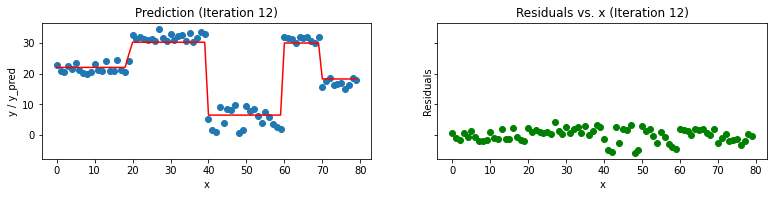

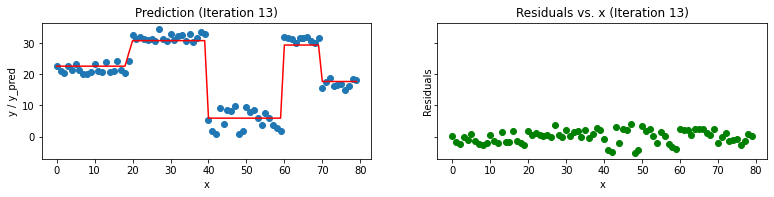

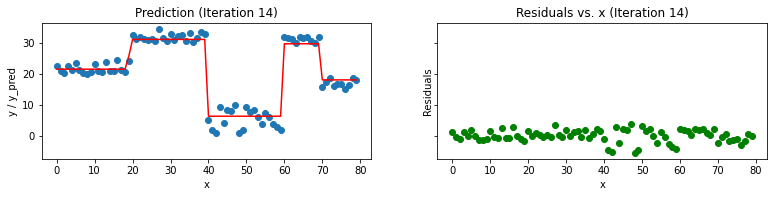

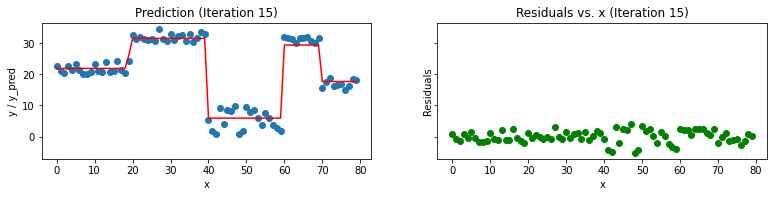

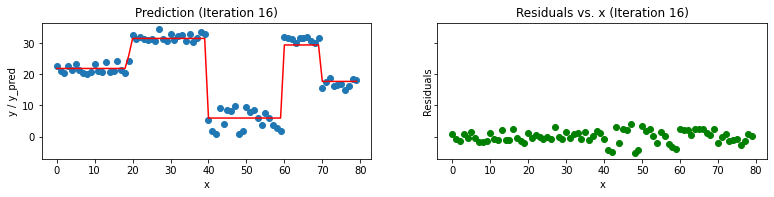

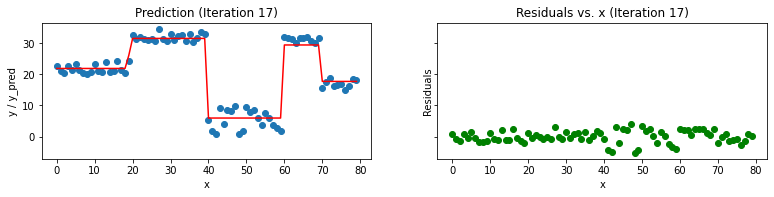

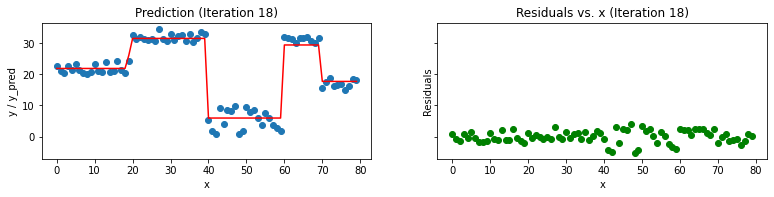

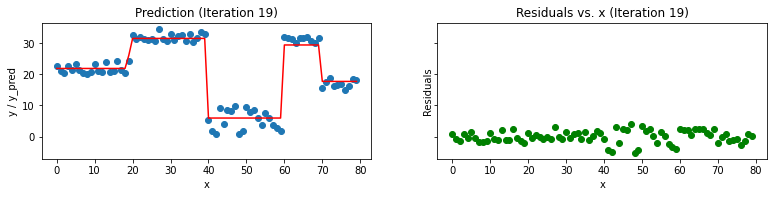

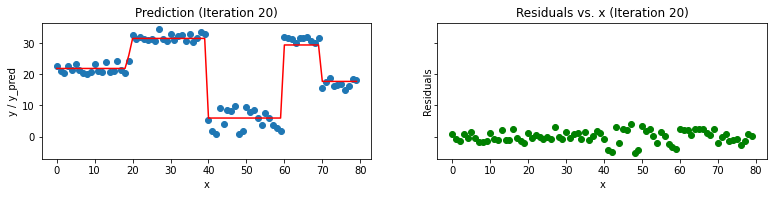

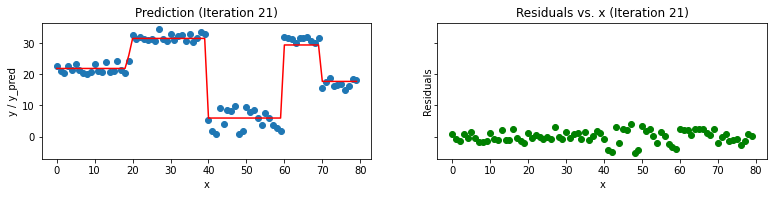

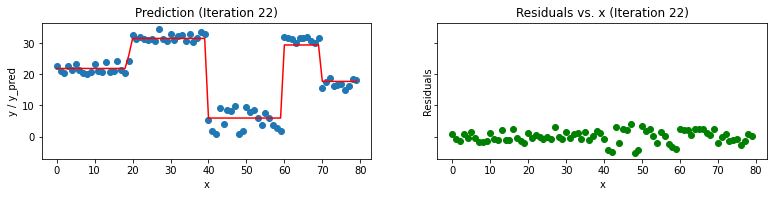

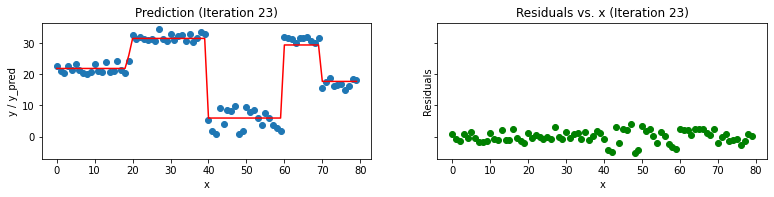

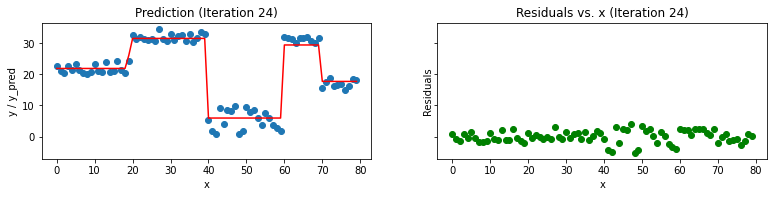

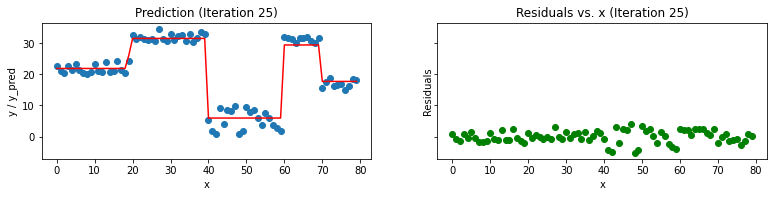

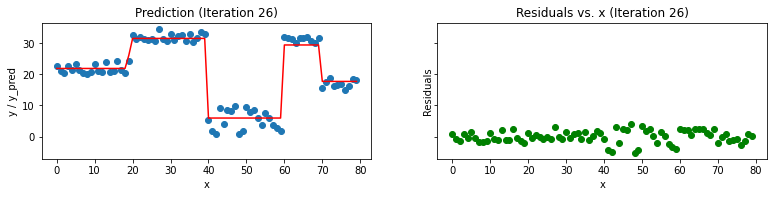

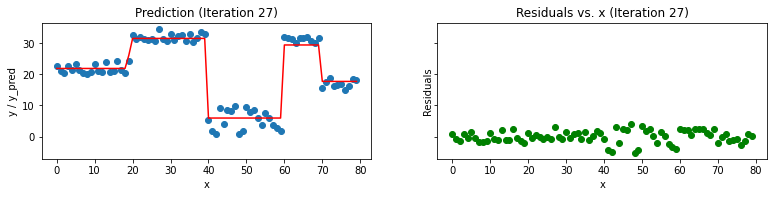

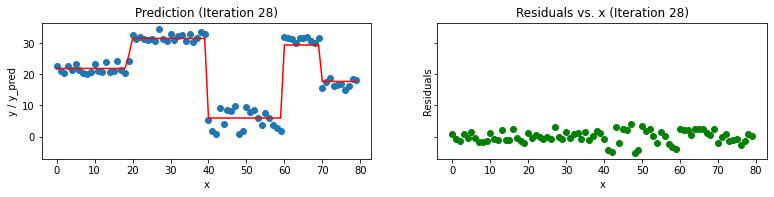

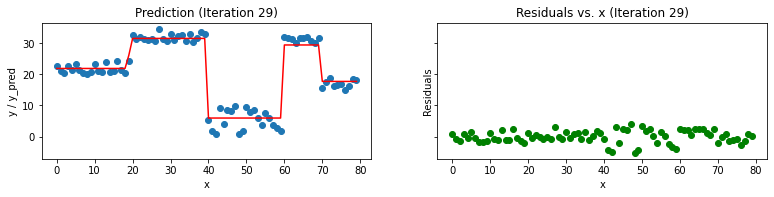

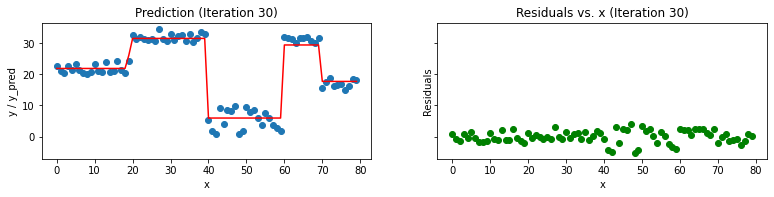

In [20]:
xi = x 
yi = y 
ei = 0 
n = len(yi)  
predf = 0

for i in range(30):
    tree = Decision_tree(xi,yi)
    tree.find_betters(0)     
    r = np.where(xi == tree.split)[0][0] 
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0] 
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r)) 
    
    predi = predi[:,None] 
    predf = predf + predi 
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
    
    